In [1]:

import os
os.environ["CURL_CA_BUNDLE"]=""
os.environ['REQUESTS_CA_BUNDLE'] = ''

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
os.environ["CUDA_VISIBLE_DEVICES"]="0"



import torch
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from diffuser_helpers_cond_uncond_lora import extract_lora_diffusers, StableDiffusionPipeline, predict_noise0_diffuser


device = "cuda:0"

# set the path to the experiment directory
dir = 'starwar'

# set paths to endpoint images
input_image_1 = f"./image/frame_0001.png"
# input_image_2 = f"./image/ana2.png"

# use the a common prompt for valid interpolation
# if you are morphing inter-class images, you shall set the prompt as 'an image of a <cls1> <cls2>' or 'an image of a <common-root-class>'
# e.g., 'an image of an animal' for cat and dog, 'an image of a poker man' for poker and man
prompt1 = 'An image of a girl holding an apple'
# prompt2 = 'photo of a man' 
lpips_delta=0.2 # delta lpips for perceptually uniform search
# Generation parameters
min_scale=1.5
max_scale=3
# choosing large inversion_step (250) is not clearly superior than smaller one (50)
inversion_steps = 250
sampling_steps=16

In [2]:
import random
import os
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(0)

In [3]:
@torch.no_grad()
def sample_model(unet, scheduler, c, scale, start_code):
    """Sample the model"""
    prev_noisy_sample = start_code
    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = unet(torch.cat([prev_noisy_sample] * 2), t, encoder_hidden_states=c).sample
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + scale * (noise_pred_text - noise_pred_uncond)
            prev_noisy_sample = scheduler.step(noise_pred, t, prev_noisy_sample).prev_sample
    return prev_noisy_sample

@torch.no_grad()
def inverse_model(x0, unet, scheduler, c):
    """Inverse the model to get noise"""
    next_noisy_sample = x0

    for t in torch.flip(scheduler_inversion.timesteps, [0]):
        with torch.no_grad():
            noise_pred = unet(torch.cat([next_noisy_sample] * 2), t, encoder_hidden_states=c).sample
            _, noise_pred_text = noise_pred.chunk(2)
            next_noisy_sample = scheduler.step(noise_pred_text, t, next_noisy_sample).prev_sample

    return next_noisy_sample
def latents_to_imgs(latents):
    x = pipe.decode_image(latents)
    x = pipe.torch_to_numpy(x)
    x = pipe.numpy_to_pil(x)
    return x

def load_img(image, target_size=(436, 1024)):
    """Load an image, resize and output -1..1"""

    tform = transforms.Compose([
        transforms.Resize(target_size),
        #transforms.CenterCrop(target_size),
        transforms.ToTensor(),
    ])
    image = tform(image)
    return 2. * image - 1.

def decode_to_img(latent, vae, vae_scaling_factor):
    decoded_output = vae.decode(latent / vae_scaling_factor)
    decoded = decoded_output.sample
    decoded_img = (decoded * 255).clamp(0, 255).to(torch.uint8)
    pil_img = Image.fromarray(decoded_img.squeeze(0).permute(1, 2, 0).cpu().numpy(), "RGB")
    return pil_img

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import DDIMScheduler #, DDIMInverseScheduler
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
model_id = "CompVis/stable-diffusion-v1-4"
dtype = torch.float32

### load model
print(f'load models from path: {model_id}')
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("test/vae", torch_dtype=dtype)
# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("test/tokenizer", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained("test/text_encoder", torch_dtype=dtype)
# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("test/unet", torch_dtype=dtype)
unet2 = UNet2DConditionModel.from_pretrained("test/unet", torch_dtype=dtype)
# 4. Scheduler for training images, eta is by default 0
scheduler_training = DDIMScheduler.from_pretrained("test/scheduler", torch_dtype=dtype)
# 5. Scheduler for sampling images, eta is by default 0
scheduler_sampling = DDIMScheduler.from_pretrained("test/scheduler", torch_dtype=dtype)
# 6. Scheduler for inversion into noise, eta is by default 0
scheduler_inversion = DDIMScheduler.from_pretrained("test/scheduler", torch_dtype=dtype)

unet = unet.to(device)
unet2 = unet2.to(device)
vae = vae.to(device)
text_encoder = text_encoder.to(device)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)
unet2.requires_grad_(False)
print(f'load models from path: {model_id}')

load models from path: CompVis/stable-diffusion-v1-4
load models from path: CompVis/stable-diffusion-v1-4


In [5]:
image_1 = Image.open(input_image_1).convert("RGB")
init_image_1 = load_img(image_1).to(device).unsqueeze(0)
init_latent_1 = vae.config.scaling_factor * vae.encode(init_image_1).latent_dist.sample()
#img1 = decode_to_im(init_latent_1).show()

text_input1 = tokenizer([prompt1], padding="max_length",
                       max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

max_length1 = text_input1.input_ids.shape[-1]


uncond_input = tokenizer(
    [""], padding="max_length", max_length=max_length1,
    return_tensors="pt"
)

with torch.no_grad():
    text_emb1 = text_encoder(text_input1.input_ids.to(device))[0]
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# original embedding = unconditional embeddings ( handle '' string) + text embedding
orig_emb1 = torch.cat([uncond_embeddings, text_emb1])
#print(orig_emb1.shape) torch.Size([2, 77, 768])

emb_1 = orig_emb1.clone()

### Text inversion

In [6]:
emb_1.requires_grad = True

lr = 2e-3
it = 2500

start_code = torch.randn_like(init_latent_1)
num_train_timesteps = len(scheduler_training.betas)
scheduler_training.set_timesteps(num_train_timesteps)
scheduler_sampling.set_timesteps(sampling_steps)
scheduler_inversion.set_timesteps(inversion_steps)

100%|██████████| 2500/2500 [15:36<00:00,  2.67it/s, loss=0.0207] 


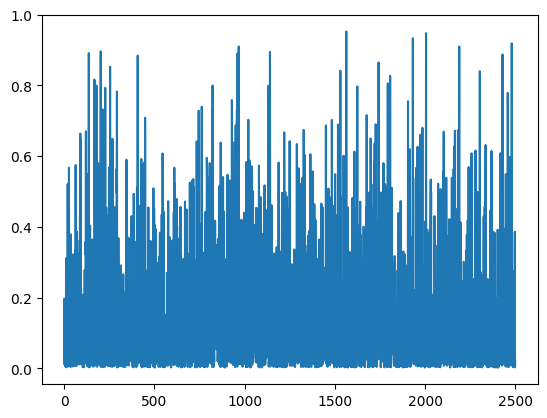

In [7]:
opt = torch.optim.Adam([emb_1], lr=lr)
criteria = torch.nn.MSELoss()
history = []
pbar = tqdm(range(it))
#emb_1_copy = emb_1.clone()
for i in pbar:
    opt.zero_grad()
    noise = torch.randn_like(init_latent_1)
    t_enc = torch.randint(num_train_timesteps, (1,), device=device)
    z = scheduler_training.add_noise(init_latent_1, noise, t_enc)
    #pred_noise = unet(z, t_enc, encoder_hidden_states=emb_1).sample
    pred_noise = predict_noise0_diffuser(unet, z, emb_1, t_enc, guidance_scale=1,scheduler=scheduler_training)
    loss = criteria(pred_noise, noise)
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    opt.step()
    #print((emb_1_copy-emb_1).norm())
plt.plot(history)
plt.show()

In [8]:
torch.cuda.empty_cache()

In [9]:
#load modified diffuser pipeline for reverse diffusion
pipe = StableDiffusionPipeline(vae,text_encoder,tokenizer,unet,scheduler_sampling,scheduler_inversion)
# noise code inversion
start_code1 = pipe.forward_diffusion(
    latents=init_latent_1,
    text_embeddings=emb_1[1].unsqueeze(0),
    guidance_scale=1,
    num_inference_steps=inversion_steps,
)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

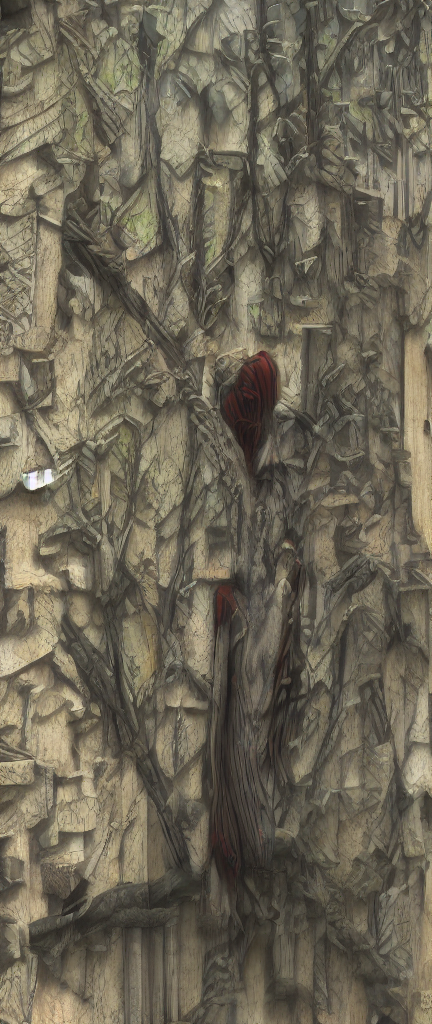

In [10]:
#random sample
# 对x_0 encode 250步, 然后对x_{250} decode sampling steps步 (= 16) 的结果
x0 = pipe.backward_diffusion(
    latents=start_code,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
latents_to_imgs(x0)[0]#.show()

variance of inverted xT: tensor(0.9781, device='cuda:0')


  0%|          | 0/16 [00:00<?, ?it/s]

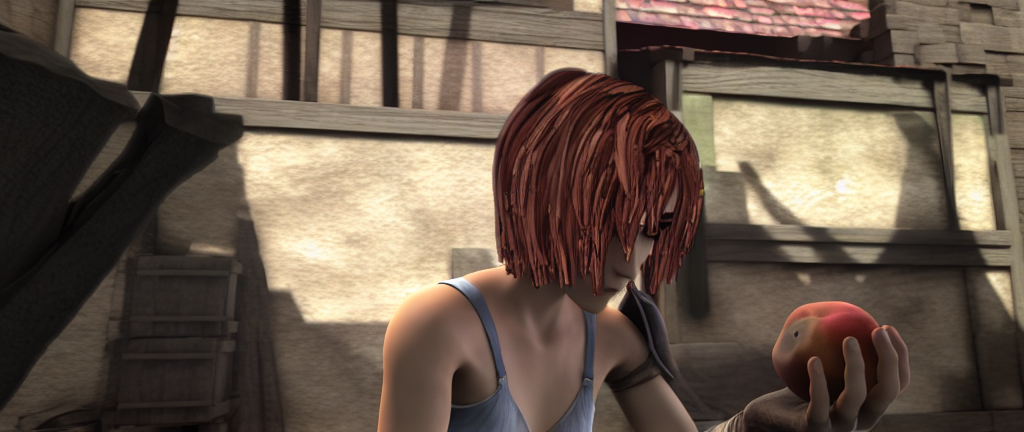

In [10]:
# sanity check for ddim inversion, should be close to 1, otherwise treated as outlier
start_code1_var = start_code1.var()
print('variance of inverted xT:', start_code1_var)
x0_1 = pipe.backward_diffusion(
    latents=start_code1,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
latents_to_imgs(x0_1)[0]#.show()

In [11]:
# 1. define distance threshold
# test distance threshold = 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
distance_threshold_01 = 0.01
distance_threshold_02 = 0.05
distance_threshold_03 = 0.1
distance_threshold_04 = 0.2
distance_threshold_05 = 0.3
distance_threshold_06 = 0.4
distance_threshold_07 = 0.5
distance_threshold_08 = 0.6
distance_threshold_09 = 0.7


# 2. Sample new potential states within a distance threshold
# Use gaussian distribution
epsilon_01 = np.random.normal(0, distance_threshold_01, start_code1.shape)
epsilon_01 = torch.tensor(epsilon_01, dtype=torch.float32).to(device)
epsilon_02 = np.random.normal(0, distance_threshold_02, start_code1.shape)
epsilon_02 = torch.tensor(epsilon_02, dtype=torch.float32).to(device)
epsilon_03 = np.random.normal(0, distance_threshold_03, start_code1.shape)
epsilon_03 = torch.tensor(epsilon_03, dtype=torch.float32).to(device)
epsilon_04 = np.random.normal(0, distance_threshold_04, start_code1.shape)
epsilon_04 = torch.tensor(epsilon_04, dtype=torch.float32).to(device)
epsilon_05 = np.random.normal(0, distance_threshold_05, start_code1.shape)
epsilon_05 = torch.tensor(epsilon_05, dtype=torch.float32).to(device)
epsilon_06 = np.random.normal(0, distance_threshold_06, start_code1.shape)
epsilon_06 = torch.tensor(epsilon_06, dtype=torch.float32).to(device)
epsilon_07 = np.random.normal(0, distance_threshold_07, start_code1.shape)
epsilon_07 = torch.tensor(epsilon_07, dtype=torch.float32).to(device)
epsilon_08 = np.random.normal(0, distance_threshold_08, start_code1.shape)
epsilon_08 = torch.tensor(epsilon_08, dtype=torch.float32).to(device)
epsilon_09 = np.random.normal(0, distance_threshold_09, start_code1.shape)
epsilon_09 = torch.tensor(epsilon_09, dtype=torch.float32).to(device)


# 3. Sample new potential state x0_2 = x0_1 + epsilon

x_01 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_01,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_02 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_02,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_03 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_03,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_04 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_04,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_05 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_05,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_06 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_06,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_07 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_07,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_08 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_08,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)
x_09 = pipe.backward_diffusion(
    latents=start_code1 + epsilon_09,
    text_embeddings=emb_1,
    guidance_scale=min_scale,
    num_inference_steps=sampling_steps,
)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [12]:
# save the output into 'res' folder
output_dir = './res'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

latents_to_imgs(x_01)[0].save(os.path.join(output_dir, 'image_01.png'))
latents_to_imgs(x_02)[0].save(os.path.join(output_dir, 'image_02.png'))
latents_to_imgs(x_03)[0].save(os.path.join(output_dir, 'image_03.png'))
latents_to_imgs(x_04)[0].save(os.path.join(output_dir, 'image_04.png'))
latents_to_imgs(x_05)[0].save(os.path.join(output_dir, 'image_05.png'))
latents_to_imgs(x_06)[0].save(os.path.join(output_dir, 'image_06.png'))
latents_to_imgs(x_07)[0].save(os.path.join(output_dir, 'image_07.png'))
latents_to_imgs(x_08)[0].save(os.path.join(output_dir, 'image_08.png'))
latents_to_imgs(x_09)[0].save(os.path.join(output_dir, 'image_09.png'))
print("Images saved to the 'res' folder.")

Images saved to the 'res' folder.


In [13]:
# save emb
if not os.path.exists(f'./{dir}/'):
    os.mkdir(f'./{dir}/')    
torch.save(emb_1, f'./{dir}/emb_1.pt')

In [14]:
emb_1 = torch.load(f'./{dir}/emb_1.pt').to(device).detach()

### Image Decoder Test

In [47]:
# test operation for vae

image_1 = Image.open(input_image_1).convert("RGB")
init_image_1 = load_img(image_1).to(device).unsqueeze(0)
init_latent_1 = vae.config.scaling_factor * vae.encode(init_image_1).latent_dist.sample()
print(init_latent_1)

tensor([[[[ 0.5001,  0.3885,  0.1290,  ..., -0.9883, -0.1442, -0.5524],
          [ 0.6963,  0.3819,  0.0898,  ..., -0.1286,  0.1964,  0.5727],
          [ 0.5772,  0.9425, -0.5604,  ...,  0.0486, -0.0123,  0.0492],
          ...,
          [-0.5391, -0.3582, -0.4433,  ..., -0.0543, -0.5767, -0.3475],
          [-0.6796, -0.4028, -1.1983,  ..., -0.4705, -0.7469, -1.0023],
          [-1.4046, -1.4265, -1.2293,  ..., -1.6473, -0.5311, -0.8908]],

         [[-0.0582, -0.2733, -0.2345,  ...,  0.3118, -0.7497,  1.0603],
          [-0.3953, -0.7843, -0.0924,  ..., -1.7821, -1.5762,  1.0442],
          [-0.5072, -0.7160, -0.0691,  ..., -0.4715, -0.9647,  1.6441],
          ...,
          [-1.2076, -2.2449, -0.6055,  ..., -1.7577, -1.6301, -1.6538],
          [-1.2666, -0.5943, -2.3685,  ..., -1.8353, -1.5792, -1.3665],
          [-1.1043, -1.1208, -1.2753,  ..., -1.0266, -1.6390, -1.8669]],

         [[ 0.1840, -0.0938,  0.2851,  ..., -0.6838,  0.0658, -0.5674],
          [ 0.3295, -0.2342, -

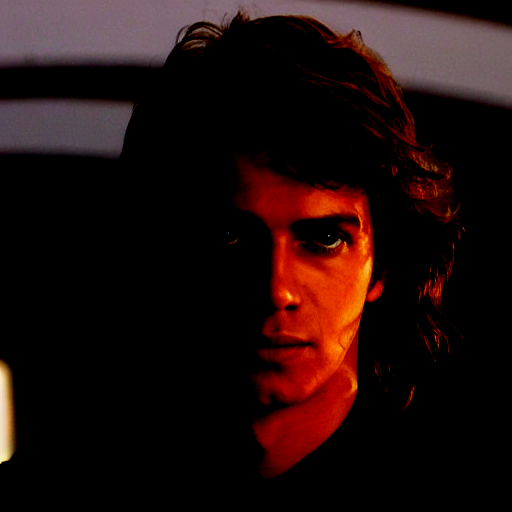

In [54]:
recover_image_1 = decode_to_img(init_latent_1, vae, vae.config.scaling_factor)
recover_image_1.show()

In [39]:
# 1. define distance threshold
distance_threshold = 0.5

# 2. Sample new potential states within a distance threshold
# Use gaussian distribution
epsilon = np.random.normal(0, distance_threshold, init_latent_1.shape)
epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

# 3. Sample new potential state x_2 = x_1 + epsilon
init_latent_2 = init_latent_1 + epsilon
print(init_latent_2)

tensor([[[[ 1.1888e+00,  1.7678e+00,  4.5840e-01,  ...,  6.1515e-01,
            7.2142e-02, -7.5500e-02],
          [ 6.6207e-01,  1.9412e+00,  1.3347e+00,  ...,  1.1676e-01,
           -3.4704e-01, -8.7750e-01],
          [ 7.8660e-01,  6.7794e-01,  4.9505e-01,  ...,  5.9237e-01,
            6.4114e-01,  2.0122e-02],
          ...,
          [-1.0343e+00, -1.6555e-01, -5.2263e-01,  ..., -6.8377e-01,
            4.3614e-03, -7.3489e-01],
          [-5.2077e-01, -4.4574e-01, -1.2982e+00,  ..., -7.0439e-01,
           -1.1763e+00, -1.9065e-01],
          [-1.2929e+00, -1.3031e+00, -1.5336e+00,  ..., -6.9430e-01,
           -5.6155e-01, -1.5489e+00]],

         [[ 3.3955e-01,  1.1073e-01,  9.5326e-01,  ..., -1.1059e+00,
           -8.5358e-01,  2.8577e-01],
          [ 1.1419e+00,  1.1059e+00, -1.6103e-01,  ..., -1.4287e+00,
           -8.2029e-01, -1.5454e+00],
          [ 1.0047e-01,  7.0220e-02,  1.4719e-01,  ..., -1.2471e+00,
           -2.9005e-01, -1.2072e+00],
          ...,
     

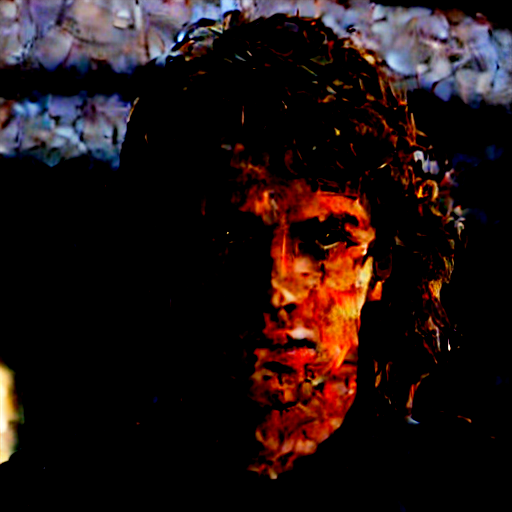

In [41]:
recover_image_2 = decode_to_img(init_latent_2, vae, vae.config.scaling_factor)
recover_image_2.show()